In [164]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightComponents.Control
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl

In [165]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#same mass in all cases
fwd_cg_pld = C172.PayloadU(m_pilot = 100, m_copilot = 100, m_baggage = 0)
aft_cg_pld = C172.PayloadU(m_pilot = 50, m_copilot = 50, m_baggage = 100)
mid_cg_pld = C172.PayloadU(m_pilot = 75, m_copilot = 75, m_baggage = 50)

design_condition_1 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 25.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 1.0,
    payload = mid_cg_pld)

design_condition_2 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 55.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 0.0,
    payload = mid_cg_pld)

ail_rud_MIMO = named_ss(ac, design_condition_2; model = :lat);

## 1. Roll Rate

In [166]:
P_a2p = ail_rud_MIMO[:p, :aileron_cmd]
zeros_p = zpkdata(P_a2p)[1][1]
ωn_p, ζ_p, poles_p = damp(P_a2p)
zeros_p |> display
poles_p |> display
ωn_p |> display
ζ_p |> display

5-element Vector{ComplexF64}:
   -0.7356908386742655 + 2.6922409948633863im
   -0.7356908386742655 - 2.6922409948633863im
  -0.10976015775064289 + 0.0im
 0.0014105434226332348 + 0.0im
 -7.144161331083059e-6 + 0.0im

11-element Vector{ComplexF64}:
 1.0474214396863987e-6 + 0.0im
  -0.02820593453671514 + 0.0im
   -0.1081000246927404 + 0.0im
   -0.7349754104430887 + 2.939344545279916im
   -0.7349754104430887 - 2.939344545279916im
   -11.541816035671967 + 0.0im
    -49.99999999999999 + 0.0im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

11-element Vector{Float64}:
  1.0474214396863987e-6
  0.02820593453671514
  0.1081000246927404
  3.0298407895172947
  3.0298407895172947
 11.541816035671967
 49.99999999999999
 62.83185307179586
 62.83185307179586
 62.83185307179586
 62.83185307179586

11-element Vector{Float64}:
 -1.0
  1.0
  1.0
  0.2425788882986763
  0.2425788882986763
  1.0
  1.0
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999

We have:
- A very fast real pole corresponding to the $\beta$ filter.
- Two pairs of very fast complex poles, corresponding to the aileron and rudder actuators
- A fast real pole, corresponding to the roll subsidence mode.
- A pair of slow, lightly damped complex poles, corresponding to the Dutch roll mode
- A slow pole, corresponding to the spiral mode. Depending on the operating condition this pole can be stable or unstable, and it has a slow zero nearby.
- A slow stable real pole, cancelled by a zero, don't know where it comes from.
- A pole at the origin, cancelled by a corresponding zero.

The near-cancellation of the spiral pole with the nearby zero suggests that the spiral mode is not fully controllable by a SISO roll rate to aileron control path only. It also means that its short-term effect in the dynamic response is negligible for the purposes of roll rate control design. We can expect that by adding sideslip control to roll rate control later on we will be able to stabilize the spiral mode.

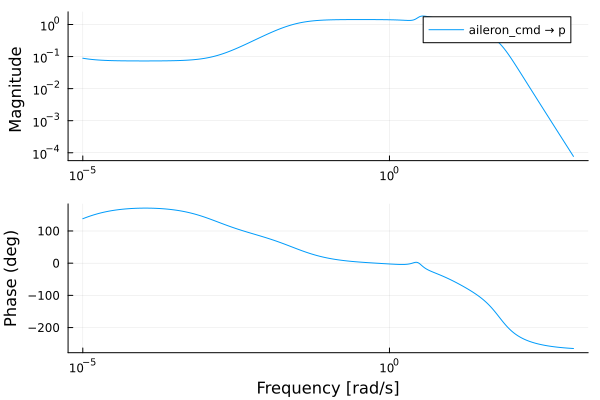

In [167]:
bodeplot(P_a2p)

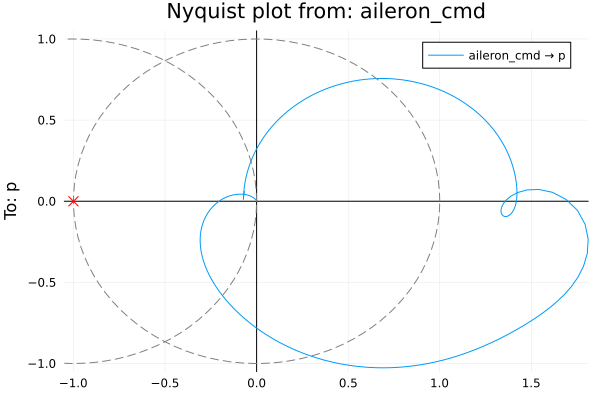

In [168]:
nyquistplot(P_a2p; unit_circle = true, Ms_circles = [1.0])
# plot!(ylims = (-2,2), xlims = (-2,2))

Because the open loop transfer function may be unstable, we cannot apply the final value theorem here. We will inspect the step response directly by simulation.

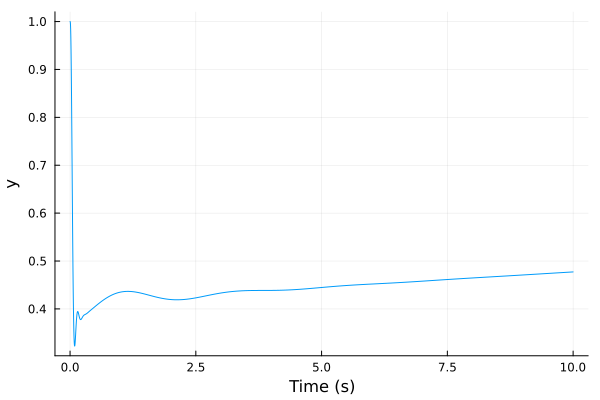

In [169]:
ε_a2p_cl = 1/(1+tf(P_a2p))
step(ε_a2p_cl, 10) |> plot

Even though the system potentially has an unstable and uncontrollable pole, we can still use PID optimization to get a useful result, in the sense of controlling the stable part of the sytem. Things to note:

- If the loop transfer function has unstable poles, one or more encirclements of (-1, 0) are required for it to be stable. Therefore, maintaining a minimum distance 1/|Ms| to (-1, 0) is no longer a guarantee of stability. However, it still is a useful metric for the short-term stability of the stable part of the system. 
- Both $\int{e}$ and $e_f$ will of course be infinite over a long enough time window, because no matter how diminished the influence of the unstable poles by corresponding zeros, they will cause divergence in the end. However, for a sufficiently small simulation time window, where their contribution is still negligible, the error metrics can still be minimized by the choice of PID parameters.

In [208]:
t_sim_p = 5
settings = PIDOpt.Settings(; t_sim = t_sim_p, maxeval = 5000)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 1, ef = 1)

# params_0 = PIDParams(; k_p = 1, k_i = 15, k_d = 0.025, τ_f = 0.01)
params_0 = PIDParams()
p_results = PIDOpt.optimize_PID(P_a2p; params_0, settings, weights, global_search = true)

@unpack k_p, k_i, k_d, T_i, T_d = p_results.params
@show k_p, k_i, k_d, T_i, T_d
@show p_results.metrics
@show p_results.cost

p_PID = PIDOpt.build_PID(p_results.params)
C_p2a = p_PID
C_p2a = named_ss(C_p2a, :pcmp; u = :p_err, y = :aileron_cmd);


(k_p, k_i, k_d, T_i, T_d) = (0.4584969650148507, 15.422110682186581, 0.015480554038273836, 0.029729845315170828, 0.03376370013217519)
p_results.metrics = [1.2375509103973876, 0.020271423450994253, 0.0016529189540043232]
p_results.cost = 0.31993666906334517


StepInfo:
Initial value:     0.000
Final value:       0.998
Step size:         0.998
Peak:              1.172
Peak time:         0.206 s
Overshoot:         17.36 %
Undershoot:         0.00 %
Settling time:     0.553 s
Rise time:         0.091 s


isstable(T_p) = false


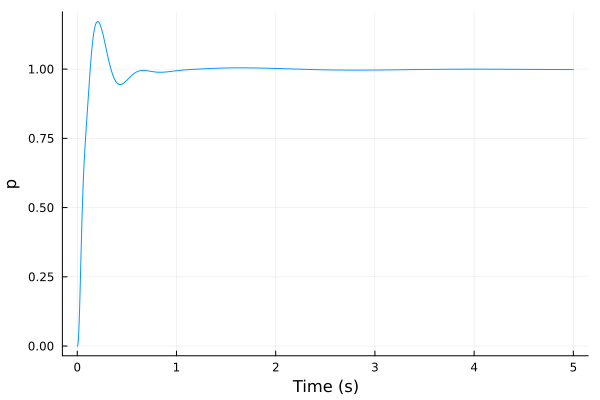

In [209]:
T_p = output_comp_sensitivity(P_a2p, C_p2a) #this is the closed loop transfer function
#we expect the roll rate-augmented closed loop system to remain unstable
@show isstable(T_p)

T_p_step = step(T_p, t_sim_p)
stepinfo(T_p_step) |> display
T_p_step |> plot

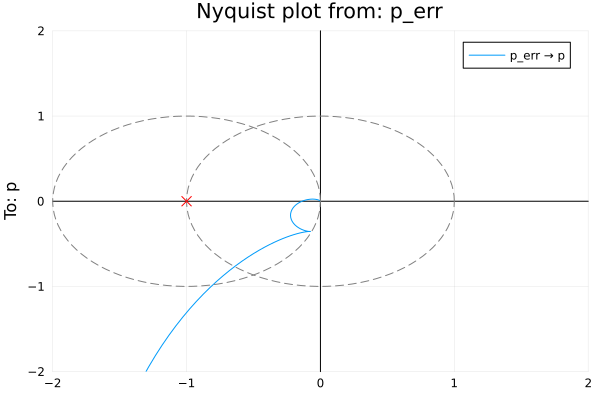

In [172]:
nyquistplot(L_p; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

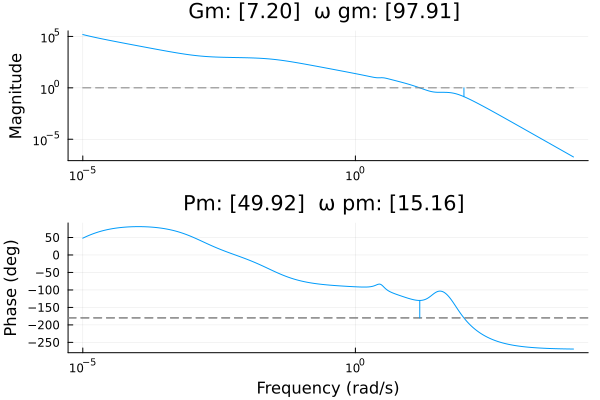

In [173]:
#like the Nyquist plot, the stability margins are not actually a guarantee in
#the presence of unstable poles, but it gives some insight about the
#minimum-phase part of the system
L_p = series(C_p2a, P_a2p)
marginplot(L_p)

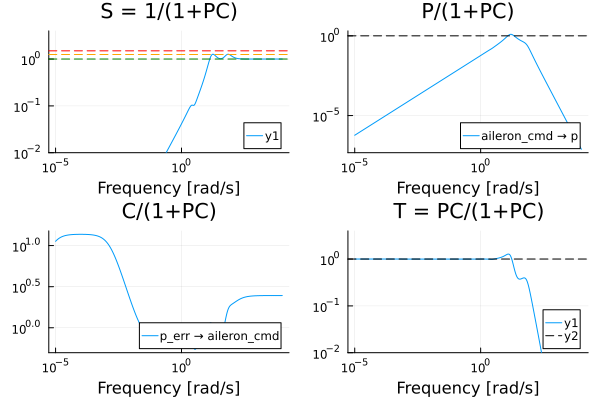

In [174]:
gangoffourplot(P_a2p, C_p2a)

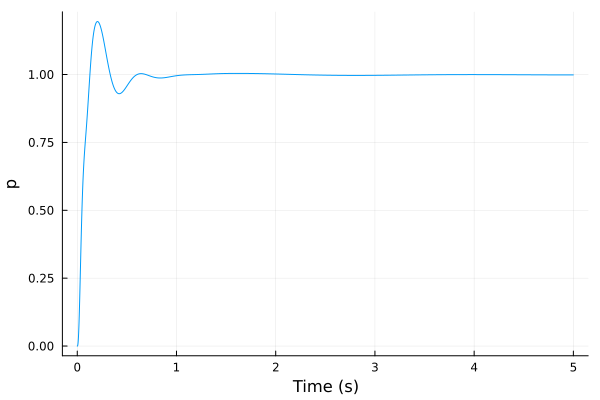

In [175]:
psum = sumblock("p_err = p_dmd - p")
p_rud_MIMO = connect([psum, C_p2a, ail_rud_MIMO], [:p_err=>:p_err, :p=>:p, :aileron_cmd=>:aileron_cmd], w1 = [:p_dmd, :rudder_cmd], z1 = ail_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
pdmd2p = p_rud_MIMO[:p, :p_dmd]
step(pdmd2p, t_sim_p) |> plot

## 2. Sideslip

The starting plant is the lateral dynamics augmented with embedded roll rate control.

In [176]:
P_r2β = p_rud_MIMO[:β, :rudder_cmd]
zpk(P_r2β) |> display
poles(P_r2β) |> display

P_r2β = minreal(P_r2β, 1e-2)
poles(P_r2β) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                        (1.0s + 108.33044869032045)(1.0s^2 + 55.04104380296559s + 3795.789404028653)(1.0s + 46.5483979664999)(1.0s^2 + 10.704087184109266s + 261.1913927466732)(1.0s + 0.11004236890116478)(1.0s - 0.0014329937943640592)(1.0s + 7.143634515619961e-6)
-179.76804272275436-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                   (1.0s + 119.28752997693536)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s^2 + 55.77039496595108s + 4535.398358476499)(1.0s^2 + 11.86235388901206s + 245.15442609765478)(1.0s^2 + 1.5176527864238936s + 7.770727999653322)(1.0s + 0.10976557509311723)(1.0s + 7.14411475124

12-element Vector{ComplexF64}:
   -119.28752997693536 + 0.0im
    -27.88519748297554 + 61.30101238814865im
    -27.88519748297554 - 61.30101238814865im
     -5.93117694450603 + 14.490533673768365im
     -5.93117694450603 - 14.490533673768365im
   -0.7588263932119468 + 2.682333033875225im
   -0.7588263932119468 - 2.682333033875225im
  -0.10976557509311723 + 0.0im
 0.0014088830089014656 + 0.0im
 -7.144114751242478e-6 + 0.0im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

10-element Vector{ComplexF64}:
  -119.28752997684906 + 0.0im
  -37.699111843077546 + 50.26548245743668im
  -37.699111843077546 - 50.26548245743668im
  -27.885197482803587 + 61.301012386061494im
  -27.885197482803587 - 61.301012386061494im
   -5.931176021446023 + 14.490533254500564im
   -5.931176021446023 - 14.490533254500564im
  -0.7588151880441321 + 2.682327057996653im
  -0.7588151880441321 - 2.682327057996653im
 -0.10977778565770033 + 0.0im

10-element Vector{ComplexF64}:
  -119.28859261131436 + 0.0im
  -27.876921613225015 + 61.299568530799164im
  -27.876921613225015 - 61.299568530799164im
   -37.70179405805612 + 50.25024665655751im
   -37.70179405805612 - 50.25024665655751im
  -5.9378815551691115 + 14.48812150245255im
  -5.9378815551691115 - 14.48812150245255im
  -0.7571508730069512 + 2.986270898916184im
  -0.7571508730069512 - 2.986270898916184im
 -0.10982002302029362 + 0.0im

ε_ir2β_cl(0) = [0.8187703178971082;;]


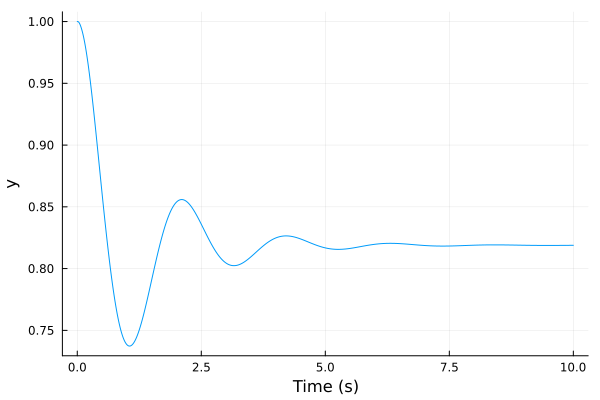

In [177]:
#the DC gain is negative. this makes sense, given that we have: act.rudder↑ ->
#aero.r↓ -> yaw↑ -> β↓. therefore, the first thing we need in the forward path
#for tracking a β command is a sign inversion in the rudder command right before
#the plant. it will take an inverted rudder_cmd from the compensator and output
#a rudder_cmd with the correct sign
rudder_inv = named_ss(ss(-1), u=:rudder_cmd_inv, y=:rudder_cmd)
ir2β = series(rudder_inv, P_r2β)

#output error transfer function for a unit feedback closed loop
ɛ_ir2β_cl = 1/(1+tf(ir2β))
ɛ_ir2β_cl |> poles |> display
@show ɛ_ir2β_cl(0) #DC gain is now positive
step(ɛ_ir2β_cl, 10) |> plot

#of course, the response is unsatisfactory, but we at least see that the sign is
#now right: the error is reduced from its initial value of 1

Again, we focus on controlling the stable and controllable part of the system, with the expectation that the combination of the (separately designed) roll rate control and sideslip control will naturally eliminate the unstable spiral pole.

In [178]:
#our optimization target plant is NOT simply P_r2β, it must include the sign inversion
P_β_opt = -P_r2β

t_sim_β = 5
settings = PIDOpt.Settings(; t_sim = t_sim_β, maxeval = 5000)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 2)
# params_0 = PIDParams(; k_p = 5, k_i = 30, k_d = 0.5, τ_f = 0.01)
params_0 = PIDParams()
β_results = PIDOpt.optimize_PID(P_β_opt; params_0, settings, weights, global_search = false)
β_PID = PIDOpt.build_PID(β_results.params)

@unpack k_p, k_i, k_d, T_i, T_d = β_results.params
@show k_p, k_i, k_d, T_i, T_d
@show β_results.metrics
@show p_results.cost


(k_p, k_i, k_d, T_i, T_d) = (7.969750037242799, 42.981331378982496, 5.446268126737991, 0.18542352648340574, 0.6833674960052036)
β_results.metrics = [1.1820720191324319, 0.02114219042142783, 2.169117280281796e-5]
p_results.cost = 0.1715611959524059


0.1715611959524059

In [179]:
β_PID = PIDOpt.build_PID(β_results.params)
C_β2r = -β_PID
C_β2r = named_ss(C_β2r, :βcmp; u = :β_err, y = :rudder_cmd);

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.001
Peak time:         0.758 s
Overshoot:          0.12 %
Undershoot:         0.00 %
Settling time:     0.328 s
Rise time:         0.200 s


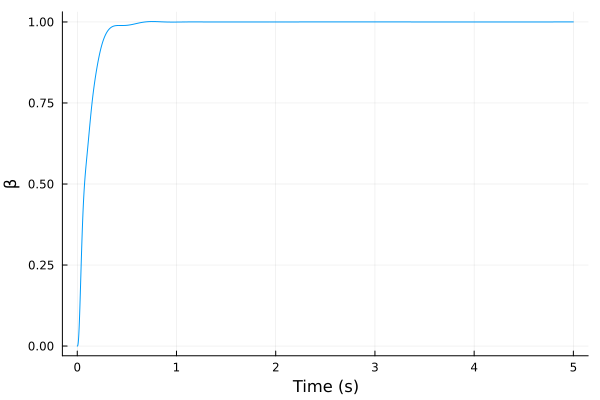

In [180]:
L_β = series(C_β2r, P_r2β)

T_β = output_comp_sensitivity(P_r2β, C_β2r) #this is the closed loop transfer function
T_β_step = step(T_β, t_sim_β)
stepinfo(T_β_step) |> display
T_β_step |> plot

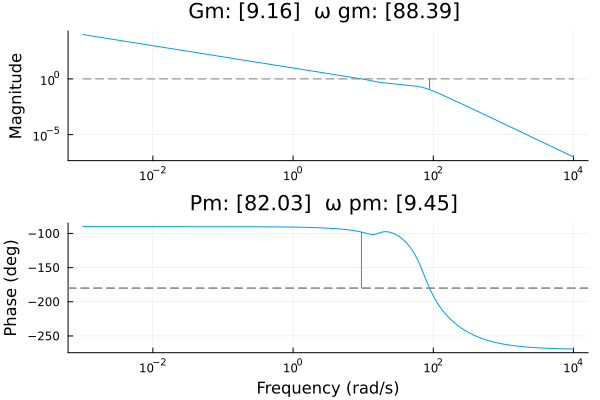

In [181]:
marginplot(L_β)

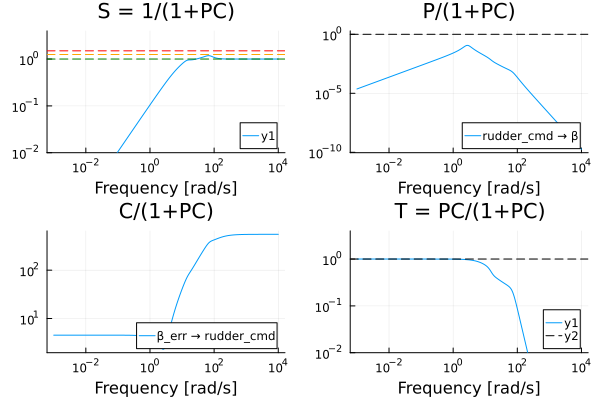

In [182]:
gangoffourplot(P_r2β, C_β2r)

In [183]:
zpkdata(T_β)[1][1] |> display
poles(T_β) |> display

9-element Vector{ComplexF64}:
  -108.33044868977504 + 0.0im
  -27.520521901091413 + 55.12177679899098im
  -27.520521901091413 - 55.12177679899098im
   -46.54839802001432 + 0.0im
   -5.352042971593303 + 15.24949169686727im
   -5.352042971593303 - 15.24949169686727im
  -0.7600086498750809 + 2.6833661585927033im
  -0.7600086498750809 - 2.6833661585927033im
 -0.11000740005041432 + 0.0im

12-element Vector{ComplexF64}:
   -123.1518120770474 + 0.0im
  -102.60369339012321 + 0.0im
  -25.392995406179658 + 64.12311767811933im
  -25.392995406179658 - 64.12311767811933im
  -32.485877739696335 + 49.57063766592976im
  -32.485877739696335 - 49.57063766592976im
    -5.33243967952658 + 14.266899124745791im
    -5.33243967952658 - 14.266899124745791im
  -10.138375199576059 + 0.0im
  -0.7596962136578879 + 2.683734567357513im
  -0.7596962136578879 - 2.683734567357513im
 -0.11001008838147697 + 0.0im

In [184]:
βsum = sumblock("β_err = β_dmd - β")
p_β_MIMO = connect([βsum, C_β2r, p_rud_MIMO], [:β_err=>:β_err, :β=>:β, :rudder_cmd=>:rudder_cmd], w1 = [:p_dmd, :β_dmd], z1 = p_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
βdmd2β = p_β_MIMO[:β, :β_dmd]
step(βdmd2β, 10) |> plot

#we see that the unstable spiral pole is (all but) naturally cancelled
zpk(βdmd2β) |> display

#p_β_MIMO is our new plant baseline: lateral dynamics with embedded roll rate
#and sideslip control and p_dmd and β_dmd as inputs
p_β_MIMO

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                     (1.0s + 108.33044869032025)(1.0s^2 + 55.04104380296562s + 3795.7894040286587)(1.0s + 46.5483979664998)(1.0s^2 + 10.704087184109271s + 261.1913927466725)(1.0s^2 + 1.5200172997501662s + 7.778067088965569)(1.0s + 0.11004236890116469)(1.0s - 0.0014329937943637204)(1.0s + 7.143634515622052e-6)
99339.2024938858---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                (1.0s + 123.1518120770645)(1.0s + 102.6036933903802)(1.0s^2 + 64.97175547047766s + 3512.580371006116)(1.0s^2 + 50.785990813874236s + 4756.578436555593)(1.0s + 10.138371211595905)(1.0s

NamedStateSpace{Continuous, Float64}
A = 
      0.0                        4.0                   0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     0.0                         0.0                      0.0                   0.0                   0.0                   0.0
     -2.33002264287061e-16     -99.99999999999999      0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     4.1630815713542914e-21     -4.433994425831212        0.0                   0.0                   0.0                   0.0
      0.0                        0.0                   0.0                  8.0                 0.0                     0.0                    0.0                     0.0                     0.0                         0.0                      0.0                   0.0                   0.0                   0.0
      0.0       

## 3. Bank Angle

In [185]:
P_p2φ = p_β_MIMO[:φ, :p_dmd]
zpk(P_p2φ)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                     (1.0s + 103.37590259039644)(1.0s^2 + 61.27774897370118s + 3383.298332626669)(1.0s^2 + 24.32271187018015s + 698.2876596725151)(1.0s + 10.684723502437988)(1.0s^2 + 1.5260803171754145s + 7.826356670554215)(1.0s + 0.11004615416151181)(1.0s + 1.1856836010368868e-7)
189230.85843334018---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 123.1518120770645)(1.0s + 102.6036933903802)(1.0s^2 + 64.97175547047766s + 3512.580371006116)(1.0s^2 + 50.785990813874236s + 4756.578436555593)(1.0s + 10.138371211595905)(1.0s^2 + 10.6

In [186]:
t_sim_φ = 5
upper_bounds = PIDParams(; k_p = 50.0, k_i = 0.0, k_d = 5.0, τ_f = 0.01) #disallow integral gain
settings = PIDOpt.Settings(; t_sim = t_sim_φ, maxeval = 5000, upper_bounds)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 2)
# params_0 = PIDParams(; k_p = 5, k_i = 30, k_d = 0.5, τ_f = 0.01)
params_0 = PIDParams()
φ_results = PIDOpt.optimize_PID(P_p2φ; params_0, settings, weights, global_search = true)
φ_PID = PIDOpt.build_PID(φ_results.params)
C_φ2p = named_ss(φ_PID, :φcmp; u = :φ_err, y = :p_dmd);

@unpack k_p, k_i, k_d, T_i, T_d = φ_results.params
@show k_p, k_i, k_d, T_i, T_d
@show φ_results.metrics
@show φ_results.cost


(k_p, k_i, k_d, T_i, T_d) = (7.957413095233845, 0.0, 0.745948280241906, Inf, 0.09374256071846987)
φ_results.metrics = [1.3234595721092726, 0.025195883617501025, 0.00019782389807843082]
φ_results.cost = 0.12121646585234151


0.12121646585234151

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.001
Peak time:         0.886 s
Overshoot:          0.03 %
Undershoot:         0.00 %
Settling time:     0.765 s
Rise time:         0.128 s


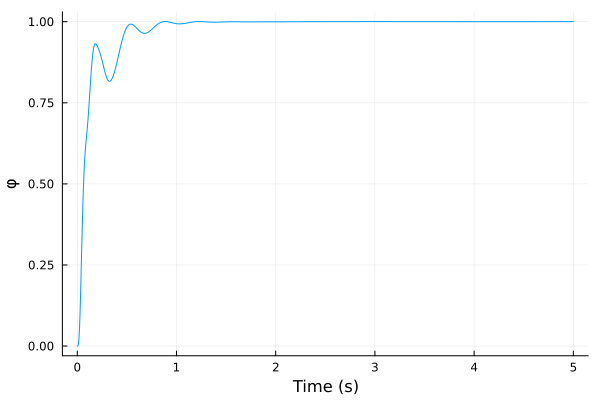

In [187]:
T_φ = output_comp_sensitivity(P_p2φ, C_φ2p) #this is the closed loop transfer function
T_φ_step = step(T_φ, t_sim_φ)
stepinfo(T_φ_step) |> display
T_φ_step |> plot

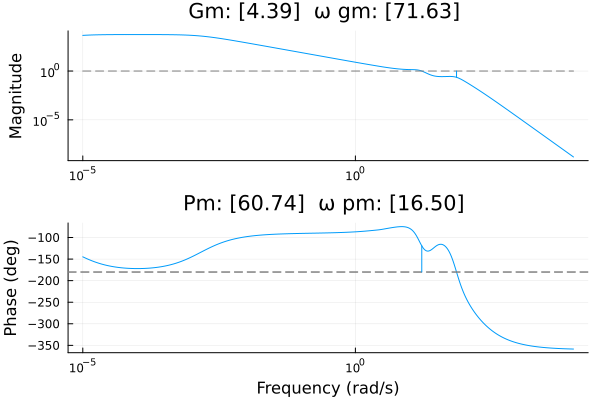

In [188]:
L_φ = series(C_φ2p, P_p2φ)
marginplot(L_φ)

In [189]:
zpk(T_φ) |> display
poles(minreal(T_φ, 1e-2)) |> display


TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                     (1.0s + 103.37590259039634)(1.0s^2 + 61.27774897370118s + 3383.298332626664)(1.0s^2 + 24.322711870180257s + 698.2876596725164)(1.0s + 9.639245388531775)(1.0s + 10.684723502437786)(1.0s^2 + 1.526080317175524s + 7.826356670554382)(1.0s + 0.11004615416151178)(1.0s + 1.1856836010304411e-7)
1.5621431452624768e7-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                    (1.0s^2 + 236.04360282970197s + 14791.410039612234)(1.0s + 103.41852246428944)(1.0s^2 + 63.59518087797031s + 3412.8016698058427)(1.0s^2 + 35

13-element Vector{ComplexF64}:
  -118.0218014518776 + 29.36433936655158im
  -118.0218014518776 - 29.36433936655158im
 -103.41852260984157 + 0.0im
 -17.862268691656627 + 65.1701767593328im
 -17.862268691656627 - 65.1701767593328im
 -31.797590437674206 + 49.00729450486918im
 -31.797590437674206 - 49.00729450486918im
  -4.310574829275212 + 17.97105096756546im
  -4.310574829275212 - 17.97105096756546im
 -10.161209959811403 + 0.0im
  -4.749960654015396 + 0.0im
 -0.7601155213465338 + 2.6923833952701783im
 -0.7601155213465338 - 2.6923833952701783im

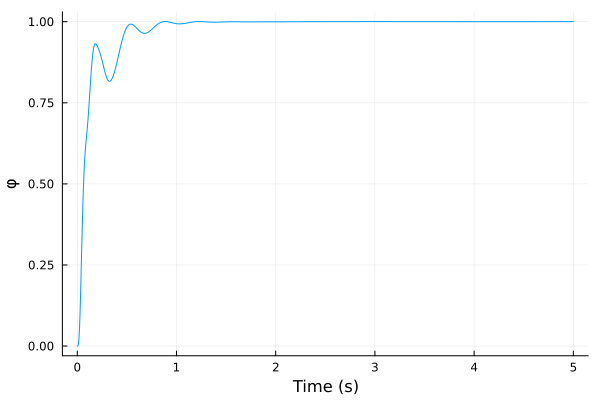

In [190]:
φsum = sumblock("φ_err = φ_dmd - φ")
φ_β_MIMO = connect([φsum, C_φ2p, p_β_MIMO], [:φ_err=>:φ_err, :φ=>:φ, :p_dmd=>:p_dmd], w1 = [:φ_dmd, :β_dmd], z1 = p_β_MIMO.y)

#check we get the same response as with the SISO closed loop
φdmd2φ = φ_β_MIMO[:φ, :φ_dmd]
step(φdmd2φ, t_sim_φ) |> plot

## 4. Course Angle

We start from the plant with embedded bank angle and sideslip control.

In [191]:
P_φ2χ = φ_β_MIMO[:χ, :φ_dmd]
P_φ2χ = minreal(P_φ2χ, 1e-2) #simplify pole-zero cancellations
zpk(P_φ2χ) |> display
isstable(P_φ2χ)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                         (1.0s + 93.17215000082092)(1.0s^2 + 68.93481815650406s + 2917.9104530239056)(1.0s^2 + 24.322711896177566s + 698.2876601625245)(1.0s + 13.782750755264717)(1.0s + 9.639364445391738)(1.0s^2 - 1.3896227289361174s + 14.836965186577165)(1.0s^2 + 1.7978966002355294s + 8.332991997660335)
165525.49847629503-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s^2 + 236.04360283166187s + 14791.410039728245)(1.0s + 103.41852246371882)(1.0s^2 + 63.595180877840214s + 3412.8016698046267)(1.0s^2 + 35.7245373979461s + 4566.212581306412)(1.0s + 10.

true

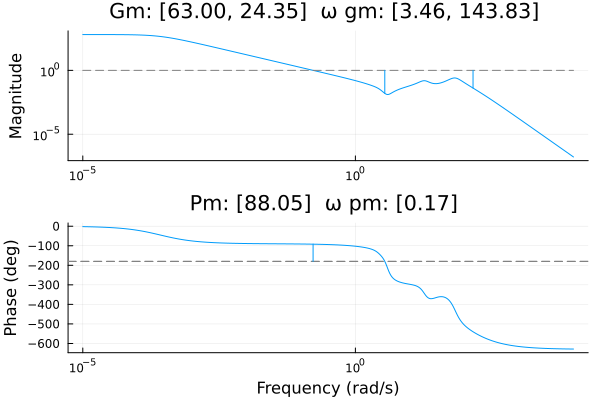

In [192]:
marginplot(P_φ2χ)

14-element Vector{ComplexF64}:
 -137.32635991133156 + 0.0im
  -99.67765010297501 + 16.922898418431437im
  -99.67765010297501 - 16.922898418431437im
 -20.197481265372225 + 70.953224240967im
 -20.197481265372225 - 70.953224240967im
  -30.47031771313308 + 47.8868412963455im
  -30.47031771313308 - 47.8868412963455im
  -4.763947117038215 + 17.808181687404847im
  -4.763947117038215 - 17.808181687404847im
 -10.146309979801341 + 0.0im
  -4.461885276852669 + 0.0im
 -0.7532825645272844 + 2.691332750252231im
 -0.7532825645272844 - 2.691332750252231im
 -0.1748038683429532 + 0.0im

ε_φ2χ_cl(0) = [0.0015659726247275489;;]


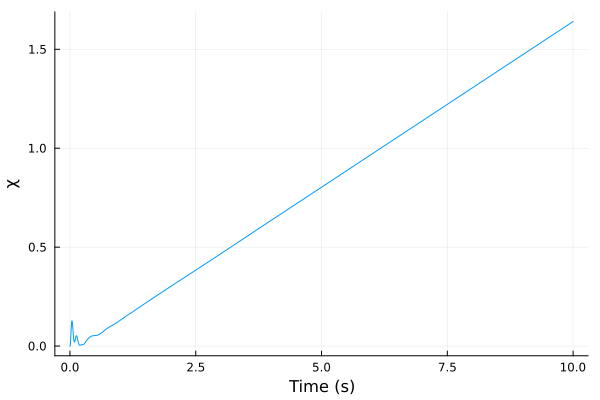

In [193]:
ɛ_φ2χ_cl = 1/(1+tf(P_φ2χ))
ɛ_φ2χ_cl |> poles |> display #all closed loop poles are stable
@show ɛ_φ2χ_cl(0) #steady state error is negligible
step(P_φ2χ, 10) |> plot

We can see that the joint bank angle and sideslip control indeed stabilize the spiral mode: the problematic pole has been naturally cancelled in the closed-loop response.

For the course angle, automatic PID optimization is not that useful. We can simply pick a set of gains that work well for a representative cruise condition and leave some stability margins for other airspeeds.

In [194]:
k_p_χ = 5
T_i_χ = 20
T_d_χ = 0.00
k_i_χ = k_p_χ / T_i_χ
k_d_χ = k_p_χ * T_d_χ
χ_PID = PIDOpt.build_PID(PIDParams(; k_p = k_p_χ, k_i = k_i_χ, k_d = k_d_χ))
C_χ2φ = named_ss(χ_PID, :χcmp; u = :χ_err, y = :φ_dmd);

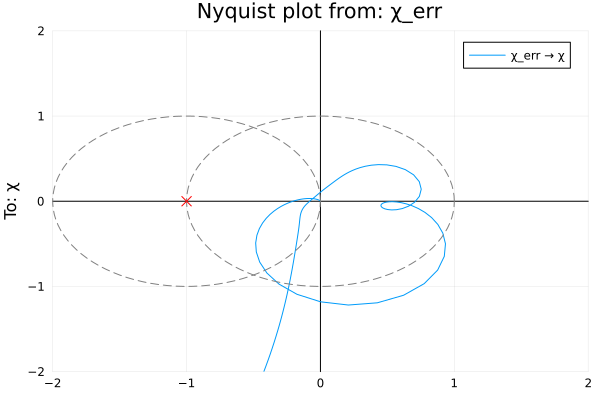

In [195]:
L_χ = series(C_χ2φ, P_φ2χ)
nyquistplot(L_χ, unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

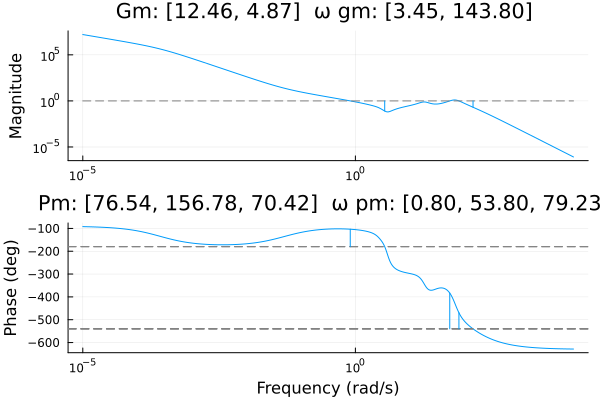

In [196]:
marginplot(L_χ)

Here we are particularly interested in the load disturbance to output transfer function P/(1+C). In order for the controller to be able to counter the effects of crosswind, this function needs to show low frequency attenuation.

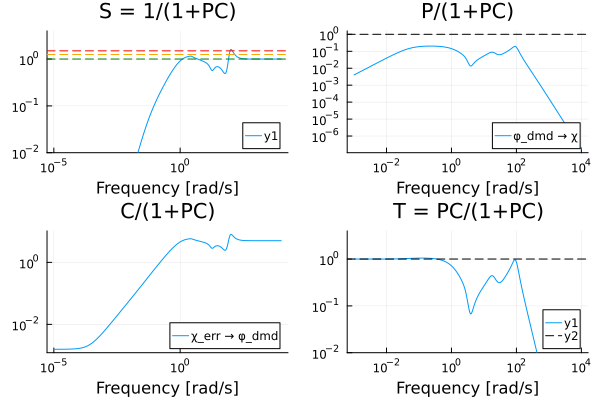

In [197]:
gangoffourplot(P_φ2χ, C_χ2φ)

For the step response it is important to consider the input to control signal response, because obviously our bank angle demand will be limited

In [198]:
T_χ = output_comp_sensitivity(P_φ2χ, C_χ2φ) #input to output response
CS_χ = G_CS(P_φ2χ, C_χ2φ) #input to control signal response
T_χ_step = step(T_χ, t_sim_χ)
CS_χ_step = step(CS_χ, t_sim_χ)
stepinfo(T_χ_step) |> display
T_χ_step |> plot
CS_χ_step |> plot!

UndefVarError: UndefVarError: `t_sim_χ` not defined